# Stock Versus Financial Indicators

### Import libraries and files

In [163]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import yfinance as yf

ModuleNotFoundError: No module named 'matplotlib.Years'

In [ ]:
# Define the path to the src directory
src_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
sys.path.insert(0, src_dir)

if 'data_loader' in sys.modules:
    del sys.modules['data_loader']
if 'data_cleaner' in sys.modules:
    del sys.modules['data_cleaner']
if 'indicators' in sys.modules:
    del sys.modules['indicators']
if 'financial_metrics' in sys.modules:
    del sys.modules['financial_metrics']

from data_loader import DataLoader
from data_cleaner import DataCleaner
from indicators import TechnicalIndicators
from financial_metrics import FinancialMetrics

In [ ]:
# File paths 
file_paths = [
    "../data/yfinance_data/AAPL_historical_data.csv",
    "../data/yfinance_data/AMZN_historical_data.csv",
    "../data/yfinance_data/GOOG_historical_data.csv",
    "../data/yfinance_data/META_historical_data.csv",
    "../data/yfinance_data/MSFT_historical_data.csv",
    "../data/yfinance_data/NVDA_historical_data.csv",
    "../data/yfinance_data/TSLA_historical_data.csv",
]

market_index_path = "../data/yfinance_data/SPY_historical_data.csv"


In [ ]:
def extract_Years(file_paths):
    """Extract the earliest and latest dates from the CSV files."""
    earliest_date = None
    latest_date = None
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        date_max = df['Date'].max()
        date_min = df['Date'].min()
        if earliest_date is None or date_min < earliest_date:
            earliest_date = date_min
        if latest_date is None or date_max > latest_date:
            latest_date = date_max
    return latest_date, earlist_date


### Download SPY data , Load and Process historical data

In [ ]:
latest_date, earlist_date = extract_dates(file_paths)
def download_spy_data(start=earlist_date, end=latest_date):
    """Download S&P 500 (SPY) data if it doesn't exist."""
    if not os.path.exists(market_index_path):
        print("Downloading S&P 500 (SPY) data...")
        spy_data = yf.download("SPY", start=start, end=end)
        os.makedirs(os.path.dirname(market_index_path), exist_ok=True)
        spy_data.to_csv(market_index_path)
        print("S&P 500 (SPY) data downloaded and saved.")
    else:
        print("S&P 500 (SPY) data already exists.")

def load_and_process_data():
    """Load and process the stock data and market index."""
    # Download SPY data if it doesn't exist
    download_spy_data()
    
    # load data
    loader = DataLoader(file_paths)
    data = loader.load_data()

    # clean data
    cleaner = DataCleaner()
    cleaned_data = {ticker: cleaner.clean_data(df) for ticker, df in data.items()}
    data = cleaned_data
    
    market_data = pd.read_csv(market_index_path, index_col='Date', parse_dates=True)
    market_returns = market_data['Close'].pct_change().dropna()
    
    indicators = TechnicalIndicators(data)
    indicators.calculate_moving_average()
    indicators.calculate_rsi()
    indicators.calculate_macd()
    
    metrics = FinancialMetrics(data)
    for ticker in data.keys():
        data[ticker]['Returns'] = data[ticker]['Close'].pct_change()
        data[ticker]['Cumulative Returns'] = (1 + data[ticker]['Returns']).cumprod()
    
    return data, market_returns

### Plots for summary statistics of the Indicators (RSI, MA, MACD, MACD_signal)

In [ ]:
def create_comparative_plots(data):
    # Prepare data
    stats = {}
    for ticker, df in data.items():
        stats[ticker] = df[['RSI', 'MA', 'MACD', 'MACD_signal']].describe().loc[['mean', 'std']]
    
    combined_stats = pd.concat(stats, axis=1)

    # Set up the plot style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # 1. Bar Plot with Error Bars
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Comparative Technical Indicators Across Stocks', fontsize=16)

    indicators = ['RSI', 'MA', 'MACD', 'MACD_signal']
    for i, indicator in enumerate(indicators):
        ax = axes[i // 2, i % 2]
        means = combined_stats.loc['mean', (slice(None), indicator)]
        stds = combined_stats.loc['std', (slice(None), indicator)]
        x = range(len(means))
        ax.bar(x, means.values, yerr=stds.values, capsize=5)
        ax.set_title(f'{indicator} - Mean with Standard Deviation')
        ax.set_ylabel('Value')
        ax.set_xticks(x)
        ax.set_xticklabels(means.index.get_level_values(0), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    # 2. Box Plot
    fig, ax1 = plt.subplots(figsize=(15, 8))
    fig.suptitle('Distribution of Technical Indicators Across Stocks', fontsize=16)

    # Prepare data
    data_melted = pd.melt(pd.concat([df[indicators].assign(Ticker=ticker) for ticker, df in data.items()]), 
                          id_vars=['Ticker'], var_name='Indicator', value_name='Value')
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()

    # Plot RSI and MA on primary y-axis
    sns.boxplot(x='Indicator', y='Value', hue='Ticker', 
                data=data_melted[data_melted['Indicator'].isin(['RSI', 'MA'])], 
                ax=ax1)
    
    # Plot MACD and MACD_signal on secondary y-axis
    sns.boxplot(x='Indicator', y='Value', hue='Ticker', 
                data=data_melted[data_melted['Indicator'].isin(['MACD', 'MACD_signal'])], 
                ax=ax2)

    # Customize the plot
    ax1.set_ylabel('RSI and MA Values')
    ax2.set_ylabel('MACD and MACD_signal Values')
    ax1.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.legend_.remove()  # Remove the second legend

    # Adjust x-axis labels
    plt.xticks(range(4), ['RSI', 'MA', 'MACD', 'MACD_signal'])
    
    plt.tight_layout()
    plt.show()

    



### Indicators vs Returns 

In [ ]:

def return_latest_year_data(data):
    # Get the most recent date in the data
    latest_date = data['Date'].max()
    
    # Calculate the date one year before the most recent date
    one_year_ago = latest_date - pd.DateOffset(years=2)
    
    # Filter the data to include only the last year
    last_year_data = data[data['Date'] >= one_year_ago]
    return last_year_data

def plot_indicators_and_returns(data, ticker):
    """Plot stock price and technical indicators for a given ticker."""
    stock_data = data[ticker]
    
   # Check if 'Date' column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(stock_data['Date']):
        stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # For closer inspection, plot only the latest year's data
    stock_data = return_latest_year_data(stock_data) 
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
    
    # Plot Close price and MA
    ax1.plot(stock_data['Date'], stock_data['Close'], label='Close Price', color='blue')
    ax1.plot(stock_data['Date'], stock_data['MA'], label='Moving Average', color='red')
    ax1.set_title(f'{ticker} Stock Price and Indicators')
    ax1.set_ylabel('Price (USD)')
    ax1.legend(loc='upper left')
    
    # Plot RSI
    ax2.plot(stock_data['Date'], stock_data['RSI'], label='RSI', color='purple')
    ax2.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
    ax2.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left')
    
    # Plot MACD
    ax3.plot(stock_data['Date'], stock_data['MACD'], label='MACD', color='blue')
    ax3.plot(stock_data['Date'], stock_data['MACD_signal'], label='Signal Line', color='orange')
    ax3.bar(stock_data['Date'], stock_data['MACD_Histogram'], label='MACD Histogram', color='gray', alpha=0.3)
    ax3.set_ylabel('MACD')
    ax3.legend(loc='upper left')
    
    # Set x-axis to show dates
    ax3.set_xlabel('Date')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax3.xaxis.set_major_locator(mdates.YearLocator())
    fig.autofmt_xdate()  # Rotate and align the tick labels
    
    # Add price to the right y-axis of RSI and MACD plots
    ax2r = ax2.twinx()
    ax2r.plot(stock_data['Date'], stock_data['Close'], alpha=0.3, color='gray')
    ax2r.set_ylabel('Price (USD)', color='gray')
    
    ax3r = ax3.twinx()
    ax3r.plot(stock_data['Date'], stock_data['Close'], alpha=0.3, color='gray')
    ax3r.set_ylabel('Price (USD)', color='gray')
    
    plt.tight_layout()
    plt.show()

def plot_returns_comparison(data):
    """Plot cumulative returns comparison for all stocks."""
   
    plt.figure(figsize=(12, 6))
    for ticker, stock_data in data.items():
        if not pd.api.types.is_datetime64_any_dtype(stock_data['Date']):
            stock_data['Date'] = pd.to_datetime(stock_data['Date'])
        plt.plot(stock_data['Date'], stock_data['Cumulative Returns'], label=ticker)
    
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

### Financial Metrics

In [ ]:
def display_metrics_table(data, market_returns):
    """Display a table of financial metrics for all stocks."""
    metrics = FinancialMetrics(data)
    sharpe_ratios = metrics.calculate_sharpe_ratio()
    volatilities = metrics.calculate_volatility()
    betas = metrics.calculate_beta(market_returns)
    
    metrics_df = pd.DataFrame({
        'Sharpe Ratio': sharpe_ratios,
        'Volatility': volatilities,
        'Beta': betas
    })
    
    display(HTML(metrics_df.to_html()))

### Correlation Heatmap 

In [ ]:
def plot_correlation_heatmap_among_tickers(data):
    """Plot correlation heatmap of stock returns."""
    returns = pd.DataFrame({ticker: stock_data['Returns'] for ticker, stock_data in data.items()})
    corr_matrix = returns.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Heatmap of Stock Returns')
    plt.show()

def plot_correlation_heatmaps_by_ticker(data):
    """Plot correlation heatmaps for each ticker based on RSI, MA, MACD, MACD_signal, MACD_Histogram, Close, and Returns."""
    for ticker, stock_data in data.items():
        # Select the relevant columns for correlation
        columns_of_interest = ['RSI', 'MA', 'MACD', 'MACD_signal', 'MACD_Histogram', 'Close', 'Returns']
        
        # Filter the DataFrame to include only the relevant columns
        ticker_data = stock_data[columns_of_interest]
        
        # Calculate the correlation matrix
        corr_matrix = ticker_data.corr()
        
        # Plot the correlation heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title(f'Correlation Heatmap for {ticker}')
        plt.show()

                  


# Data Processing and Visualizations starts here

In [ ]:
# Main execution
data, market_returns = load_and_process_data()

S&P 500 (SPY) data already exists.


## Indicators | Summary statistics

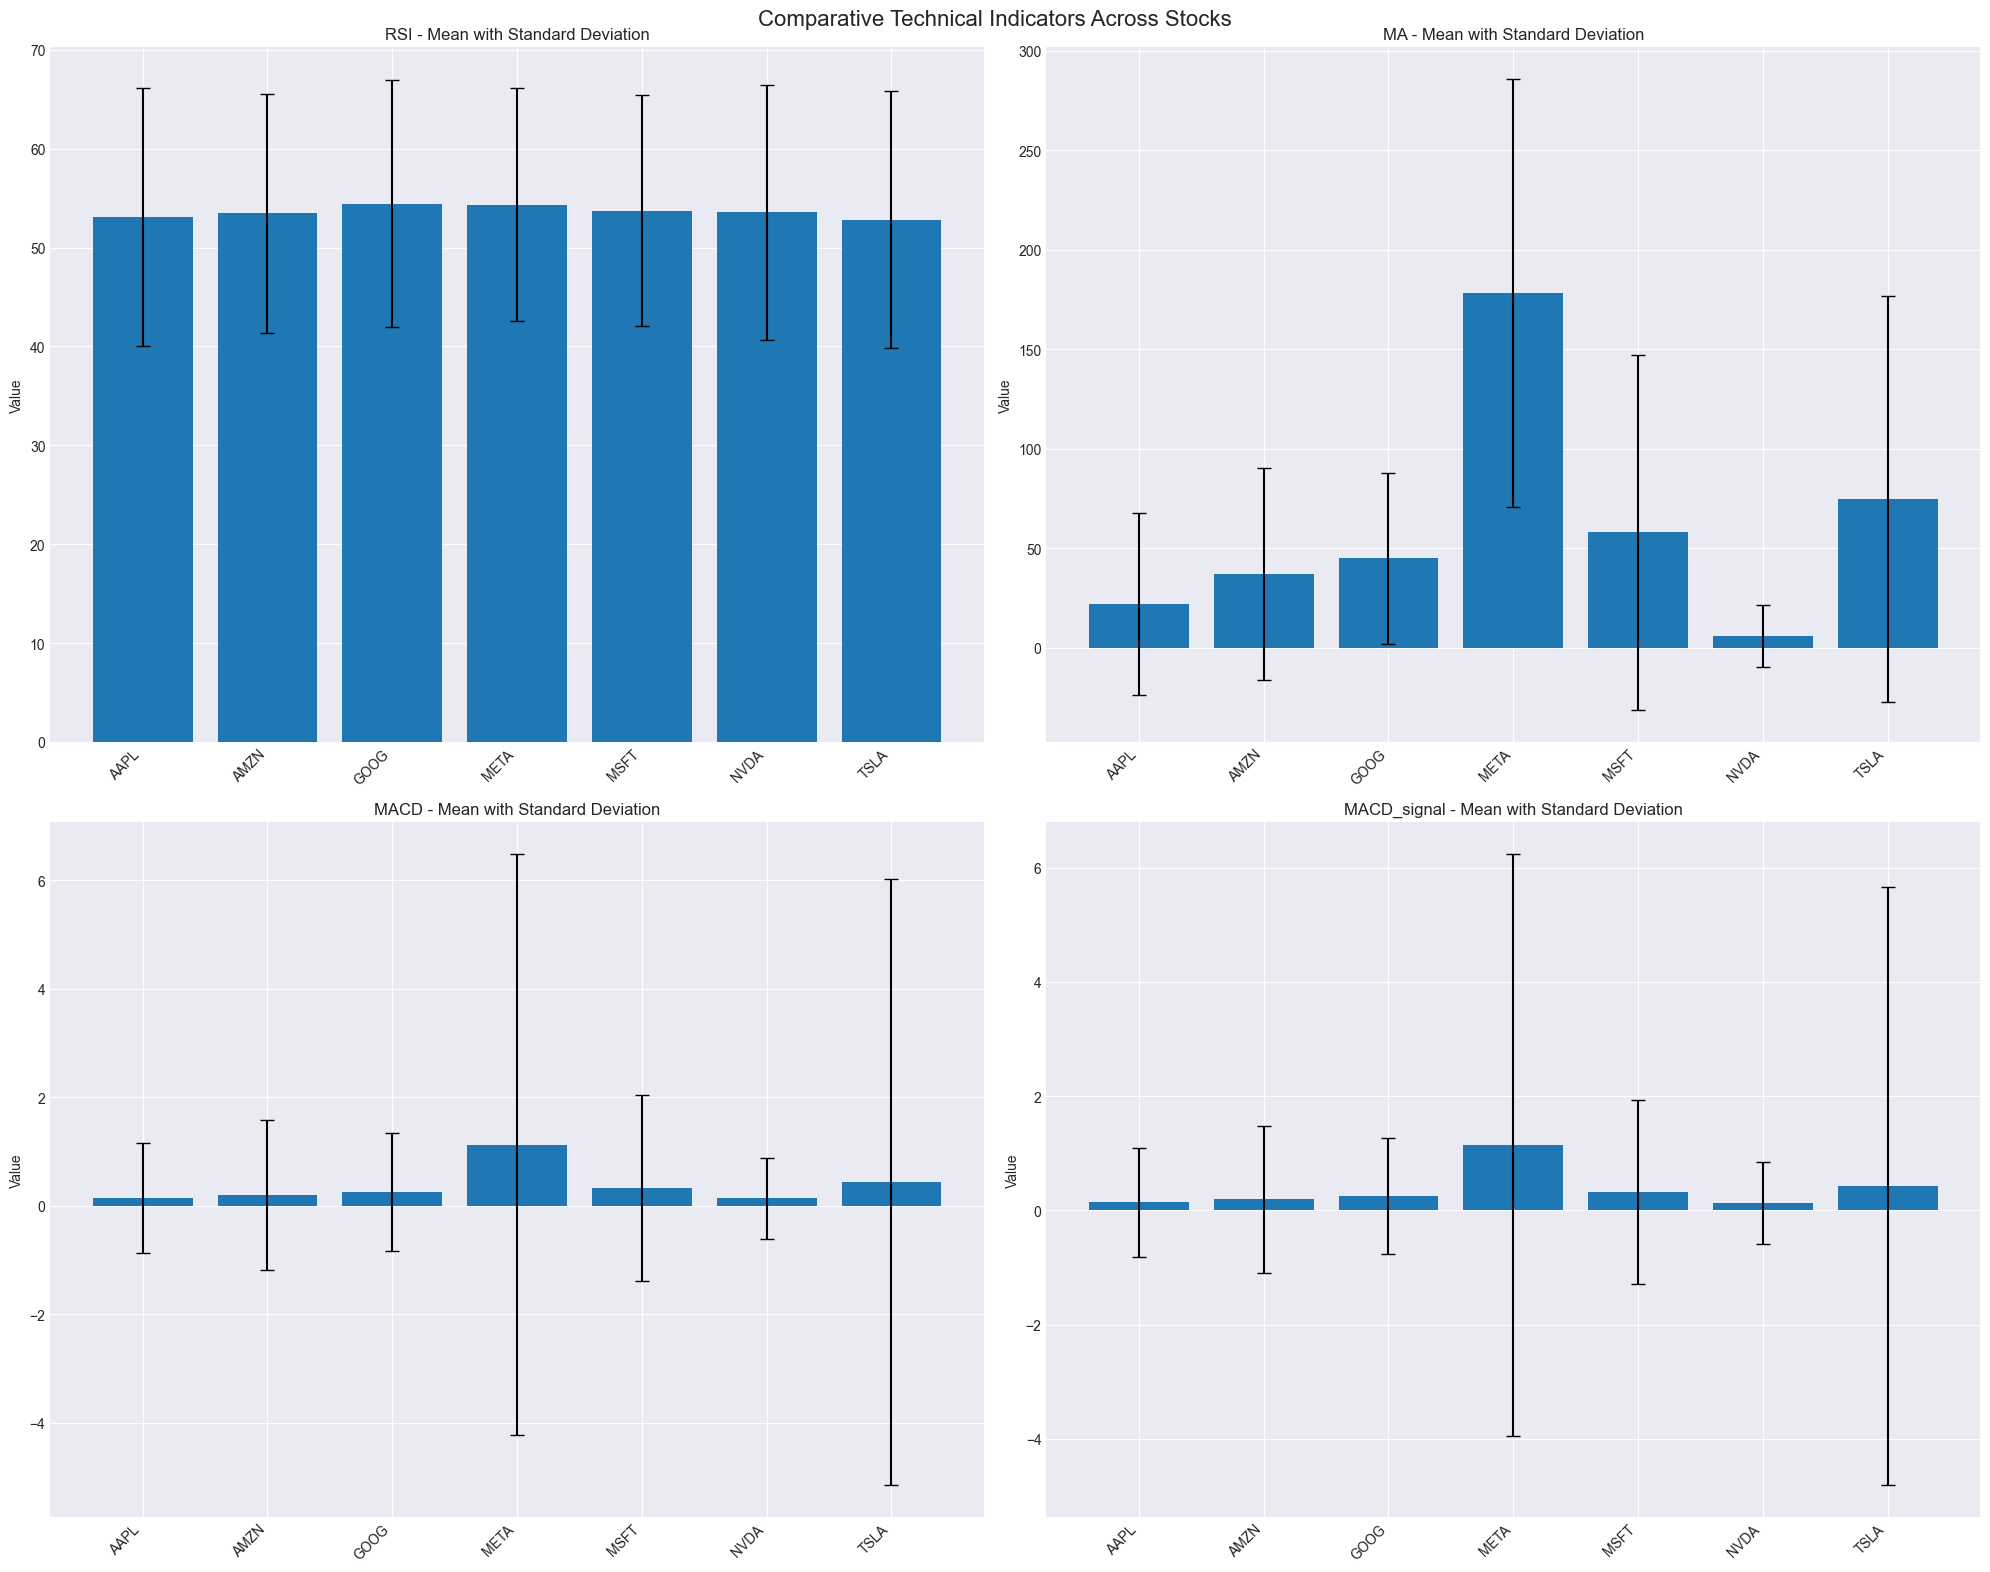

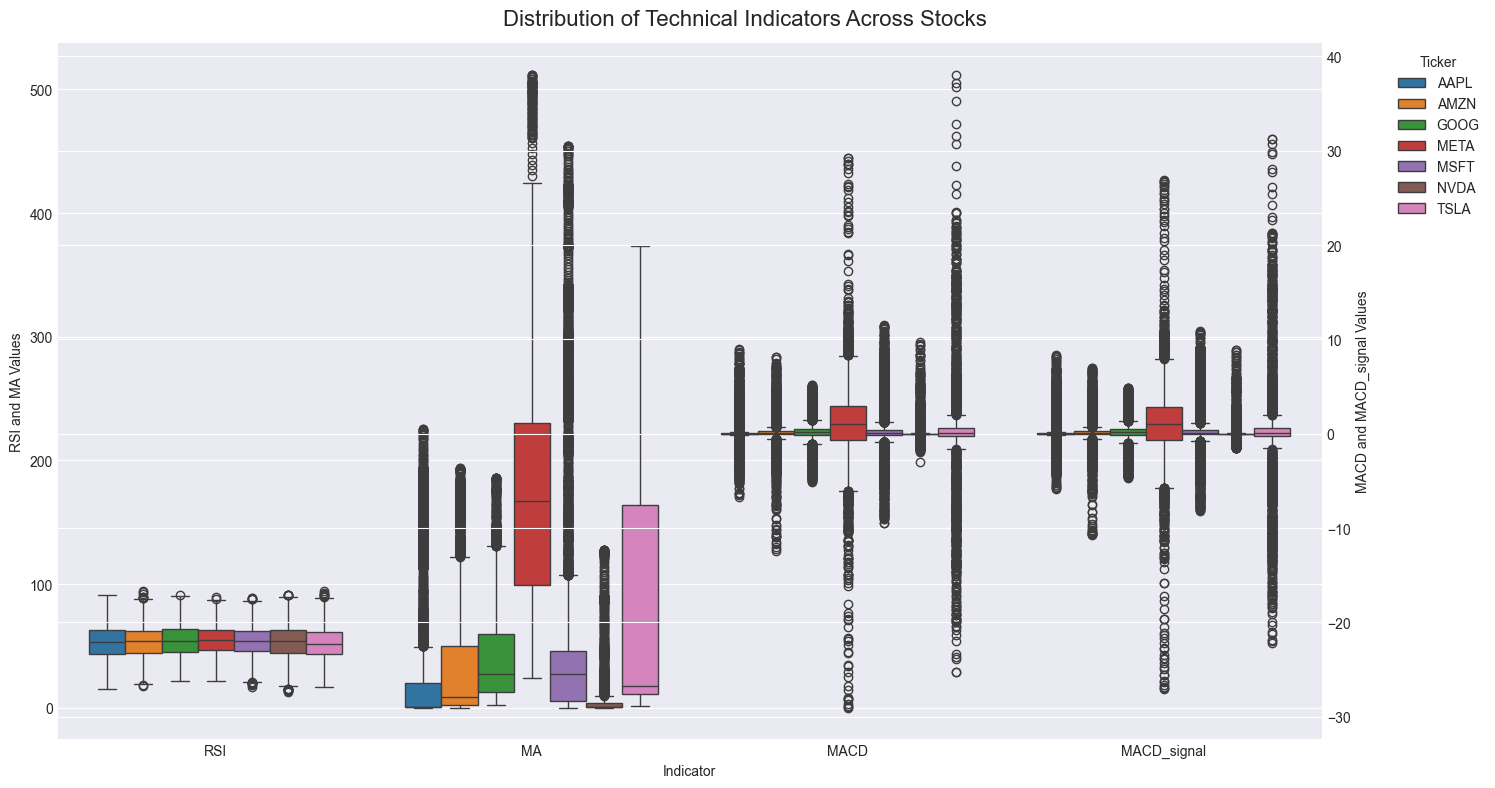

In [ ]:
create_comparative_plots(data)

## Indicators vs Returns

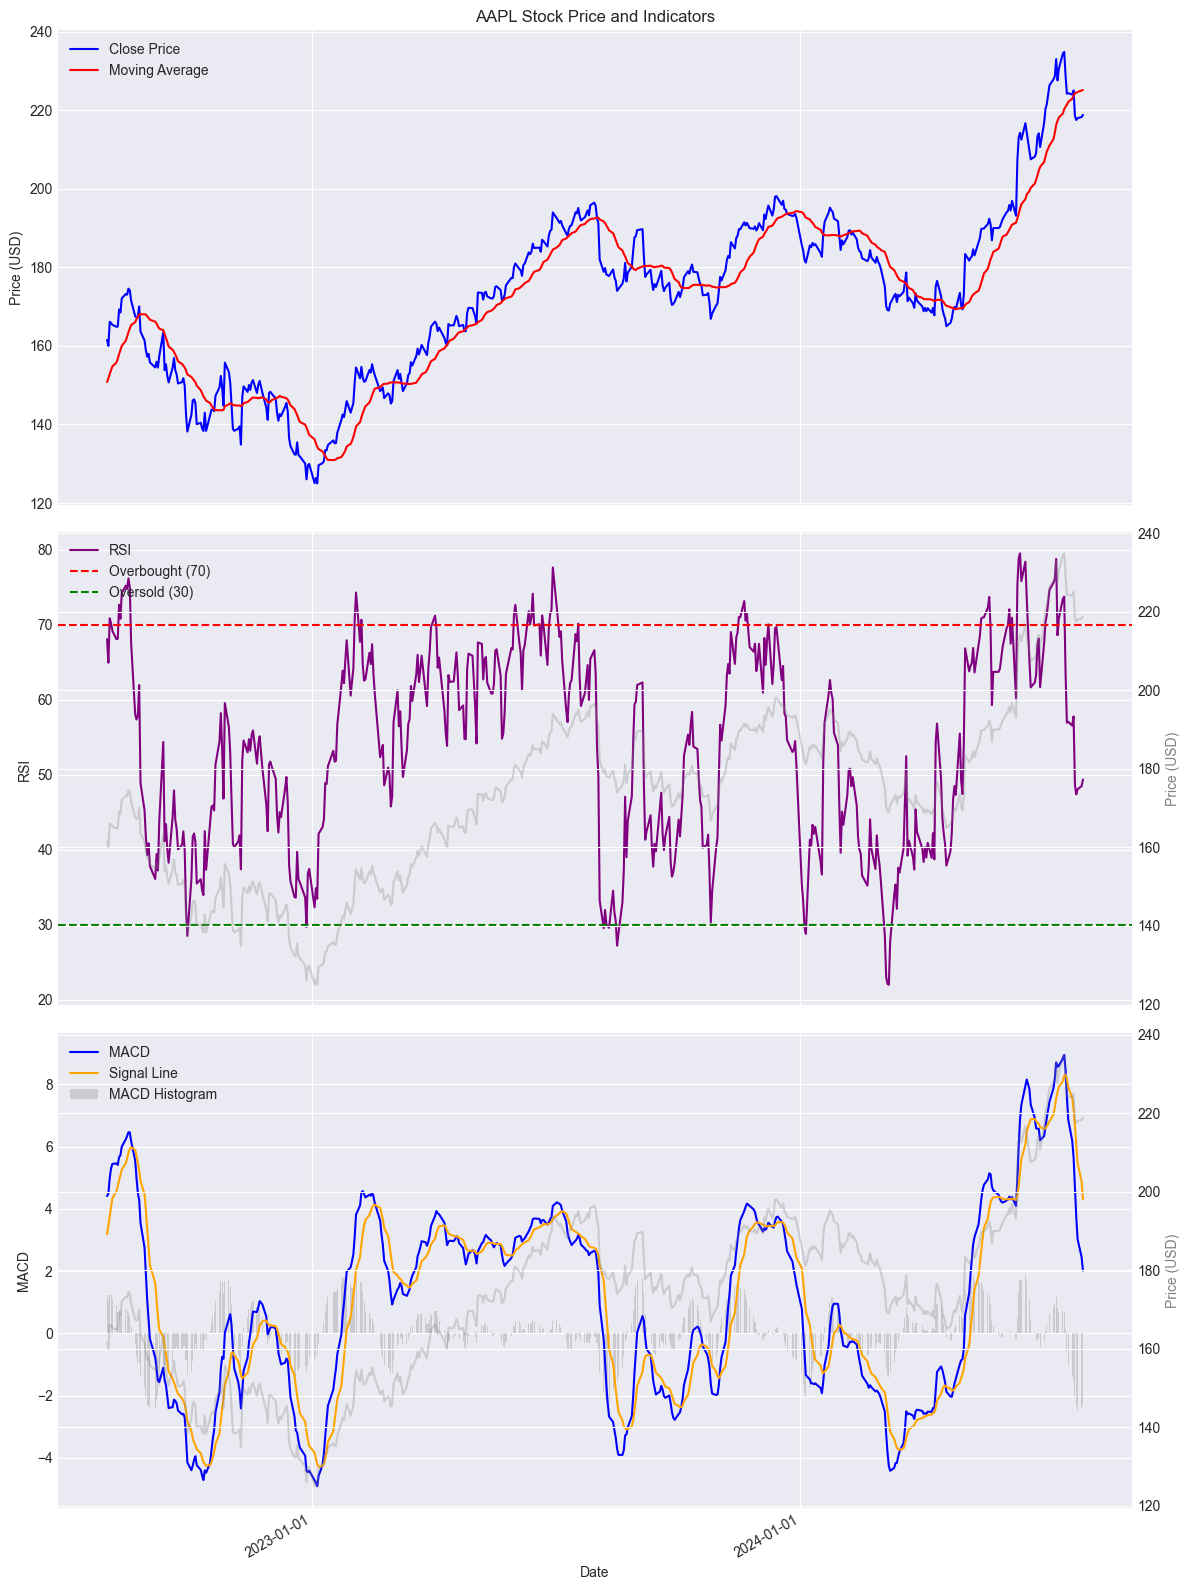

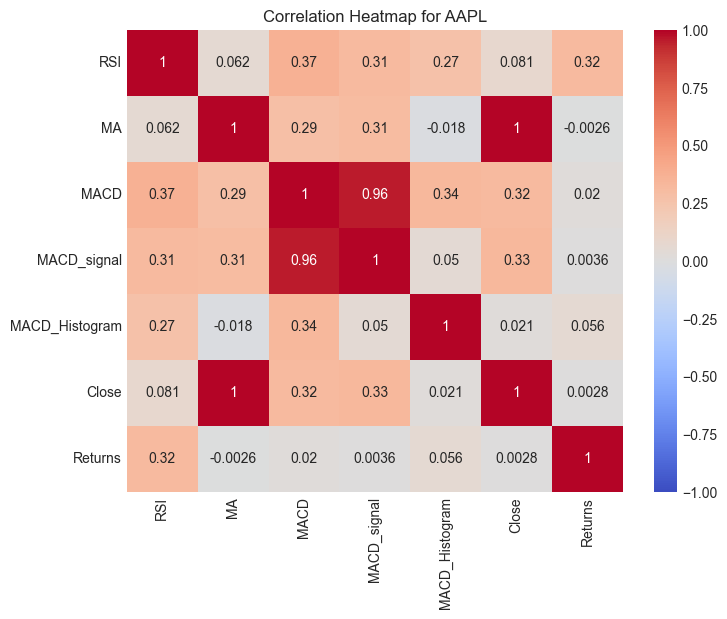

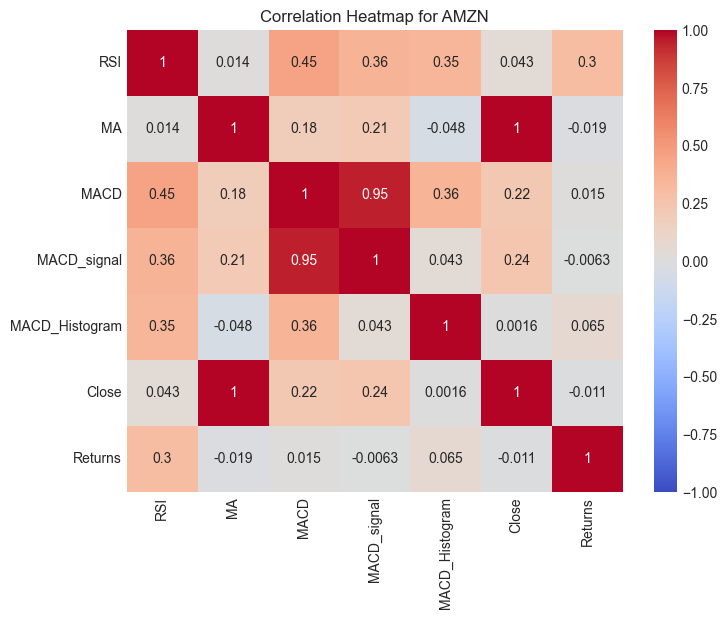

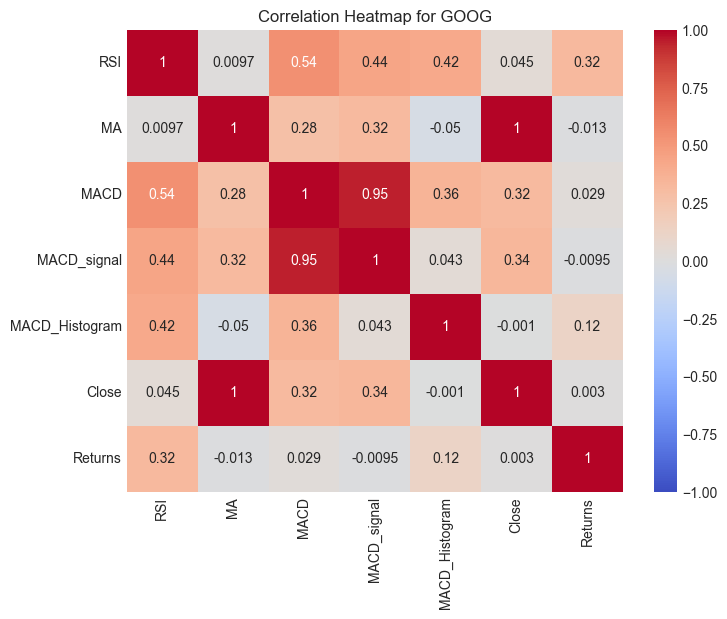

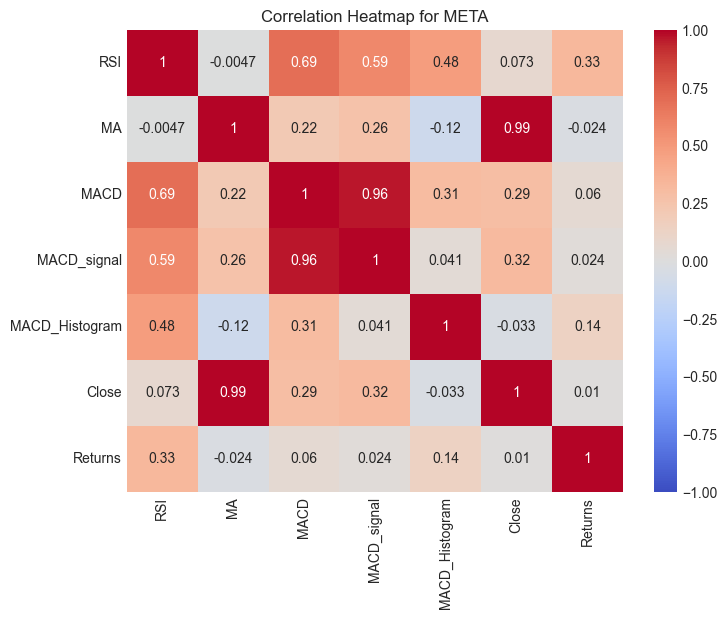

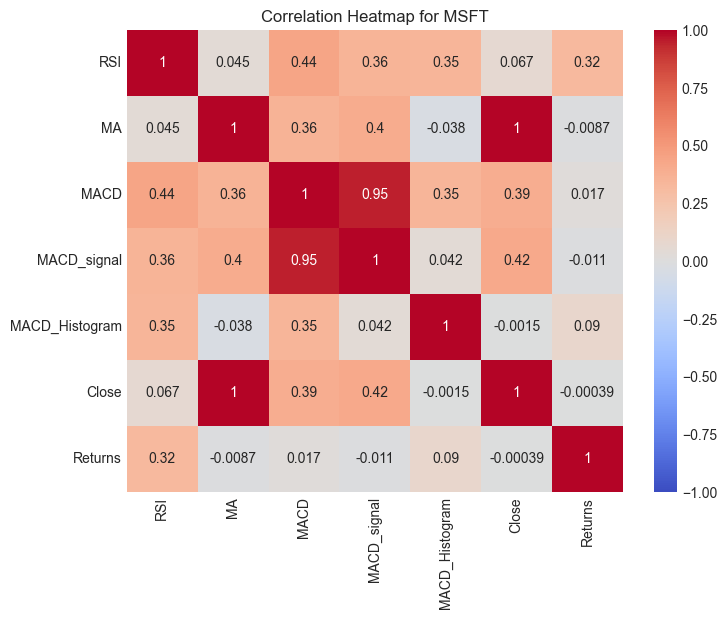

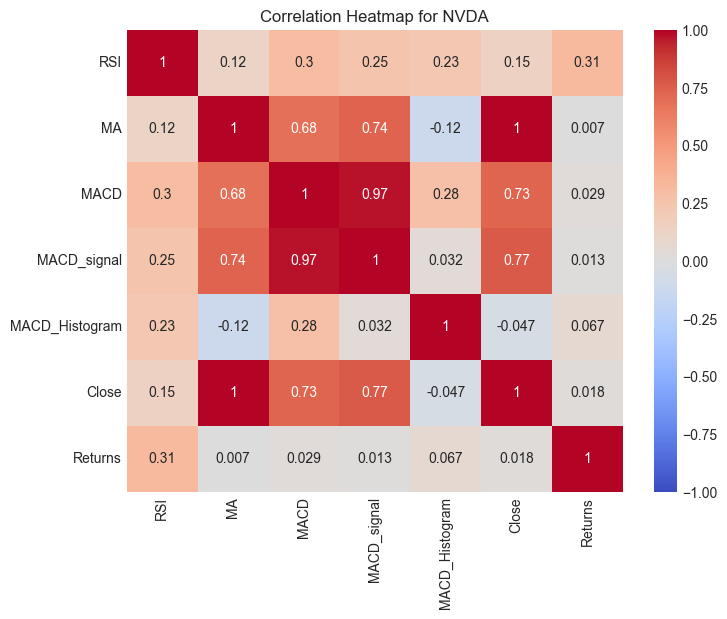

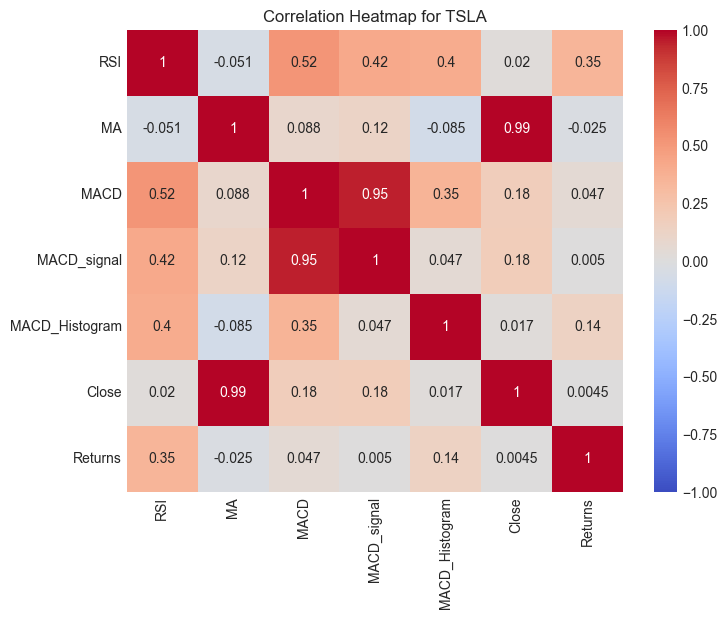

In [ ]:
plot_indicators_and_returns(data, 'AAPL')
plot_correlation_heatmaps_by_ticker(data)
    

## Relationship among tickers

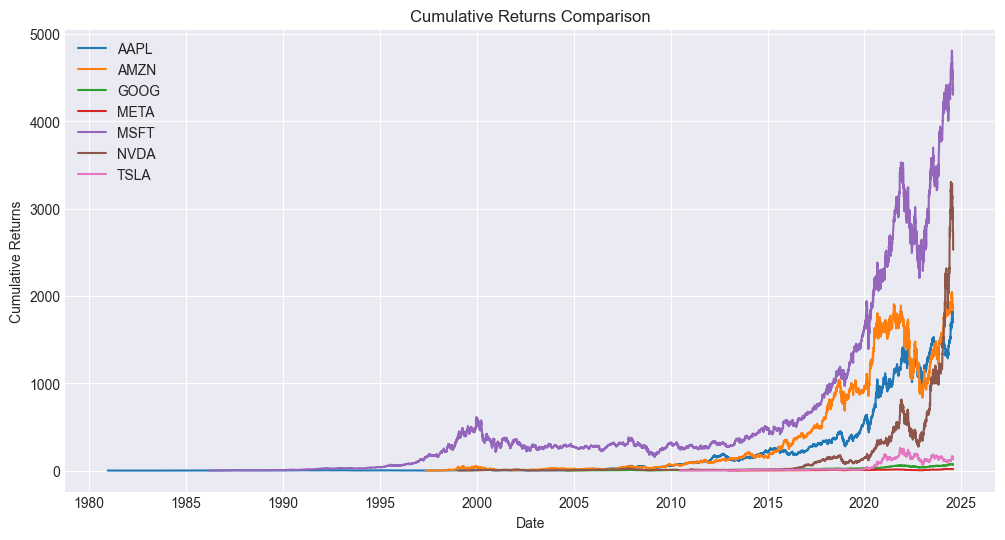

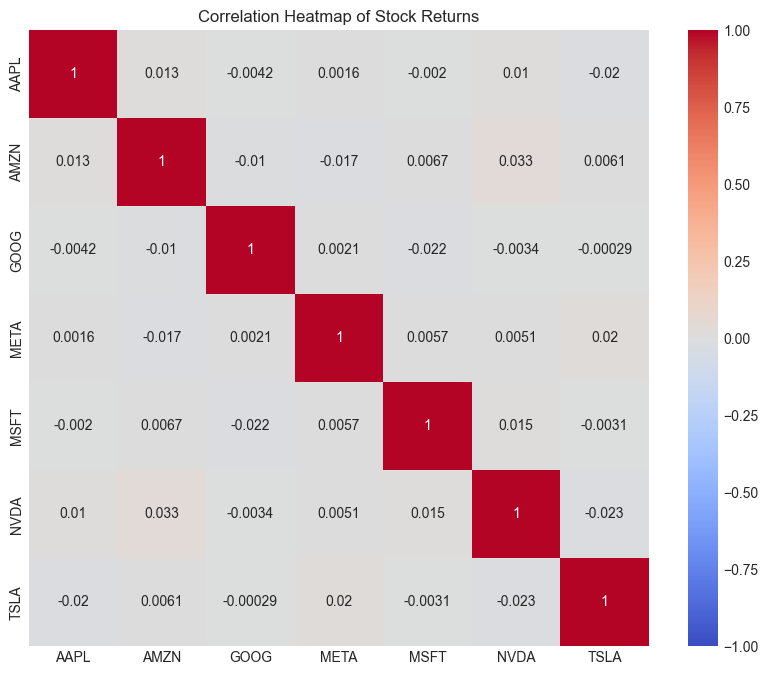

In [ ]:
plot_returns_comparison(data)
plot_correlation_heatmap_among_tickers(data)


## Financial Metrics | sharpe_ratio, volatility, beta

In [ ]:
# Display metrics table
print("Financial Metrics:")
display_metrics_table(data, market_returns)

Financial Metrics:


e:\Studies\tenx\w1\venv\lib\site-packages\numpy\lib\function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
e:\Studies\tenx\w1\venv\lib\site-packages\numpy\core\_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
e:\Studies\tenx\w1\src\financial_metrics.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(aligned_returns[0], aligned_returns[1])[0][1]
e:\Studies\tenx\w1\venv\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
e:\Studies\tenx\w1\venv\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,Sharpe Ratio,Volatility,Beta
AAPL,0.038450,0.014266,NaN
AMZN,0.048431,0.017436,NaN
GOOG,0.053241,0.017196,NaN
META,0.051885,0.023030,NaN
MSFT,0.051624,0.012393,NaN
NVDA,0.051038,0.029733,NaN
TSLA,0.056727,0.033623,NaN


In [ ]:
print("Market Returns:")
print(market_returns)

Market Returns:
Date
1993-02-01    0.007112
1993-02-02    0.002119
1993-02-03    0.010571
1993-02-04    0.004184
1993-02-05   -0.000694
                ...   
2024-07-23   -0.001569
2024-07-24   -0.022663
2024-07-25   -0.005210
2024-07-26    0.011200
2024-07-29    0.000588
Name: Close, Length: 7929, dtype: float64


In [ ]:
df = data['AMZN']
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits,MA,RSI,MACD,MACD_signal,MACD_Histogram,Returns,Cumulative Returns,Year
1970-01-01 00:00:00.000000000,1997-05-15 00:00:00+00:00,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000,0.0,0.0,0.078737,30.391897,-0.000362,-0.000402,0.00004,NaN,NaN,1997
1970-01-01 00:00:00.000000001,1997-05-16 00:00:00+00:00,0.098438,0.098958,0.085417,0.086458,0.086458,294000000,0.0,0.0,0.078737,30.391897,-0.000362,-0.000402,0.00004,-0.117028,0.882972,1997


In [ ]:
print(earlist_date)

1980-12-12


In [ ]:
print(latest_date)

2024-07-30
